In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import r2_score, mean_squared_error

from helper import *

In [286]:
df = pd.read_csv('../data/train.csv')
#df.head()

In [287]:
#df.drop(['Id'], axis=1, inplace=True)
#df.info()

In [288]:
numeric_df = df.select_dtypes(include=[np.number])
print(numeric_df.columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [289]:
count_nulls(numeric_df)

,nulls,percent_missing
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479


## Estimating LotFrontage
fill in NA values better than simply using the mean

In [290]:
LotFrontage_df = numeric_df.dropna(subset=['LotFrontage'])
LotFrontage_df.corr()['LotFrontage'].sort_values(ascending=False)[0:6]

LotFrontage     1.000000
1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
Name: LotFrontage, dtype: float64

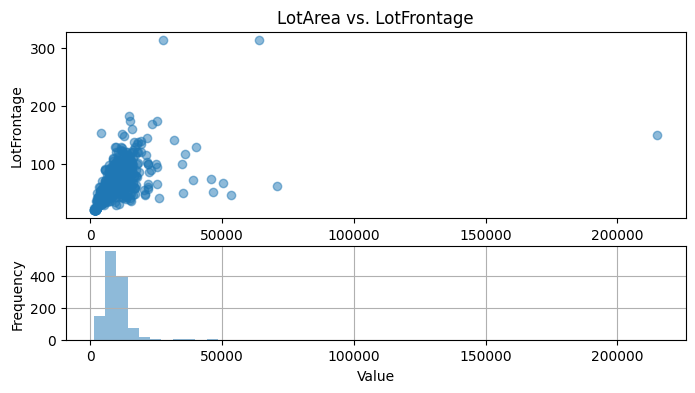

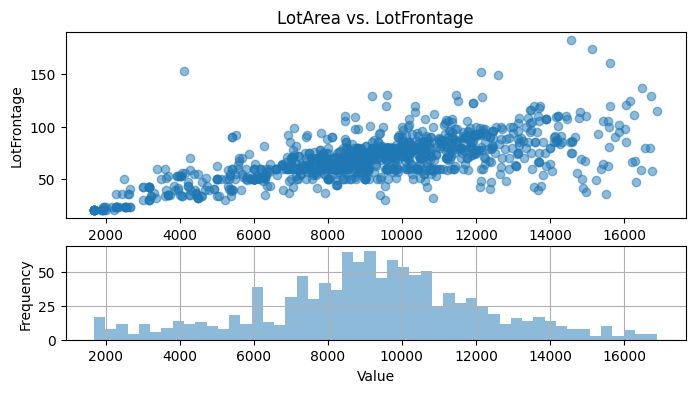

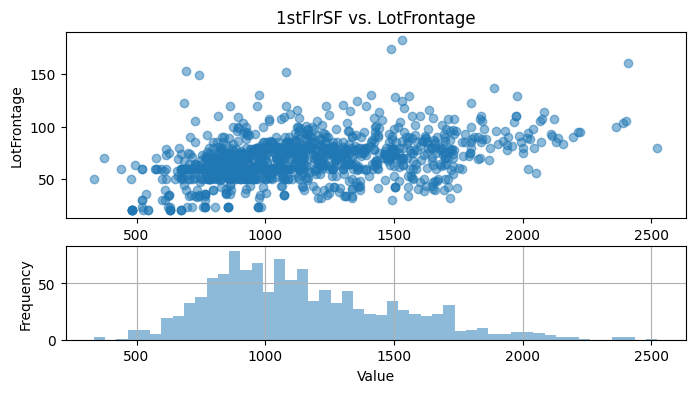

In [ ]:
ajr_plot_scatter_volume(LotFrontage_df, 'LotArea', 'LotFrontage', fig_height=8)

def iqf(data: pd.DataFrame, column: str) -> pd.DataFrame:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] > lower_bound) & (data[column] < upper_bound)]

LotFrontage_df = iqf(LotFrontage_df, 'LotArea')

ajr_plot_scatter_volume(LotFrontage_df, 'LotArea', 'LotFrontage', fig_height=8)
ajr_plot_scatter_volume(LotFrontage_df, '1stFlrSF', 'LotFrontage', fig_height=8)
#ajr_plot_scatter_volume(LotFrontage_df, 'GrLivArea', 'LotFrontage', fig_height=8)
#ajr_plot_scatter_volume(LotFrontage_df, 'TotalBsmtSF', 'LotFrontage', fig_height=8)

In [292]:
LotFrontage_top_features = numeric_df.corr()['LotFrontage'].sort_values(ascending=False)[1:6].index.to_list()
LotFrontage_top_features

['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF', 'TotRmsAbvGrd']

In [293]:
# List of models
models = [LinearRegression(), RandomForestRegressor(), SVR(), KNeighborsRegressor(),
          DecisionTreeRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(),
          BaggingRegressor(), ExtraTreesRegressor()]

# Find the best combination of features and model
best_combination, best_model, best_accuracy = ajr_find_best_combination(LotFrontage_top_features, 'LotFrontage', LotFrontage_df, models)

best_combination = list(best_combination)

print(f"Best feature combination: {best_combination}")
print(f"Best model: {best_model} with accuracy: {best_accuracy}")

100%|██████████| 31/31 [00:09<00:00,  3.17it/s]

Best feature combination: ['1stFlrSF', 'LotArea', 'GrLivArea']
Best model: RandomForestRegressor() with accuracy: 0.47846417519775064


In [294]:
model = RandomForestRegressor()
X = LotFrontage_df[['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']]
y = LotFrontage_df['LotFrontage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2}")
print(f"MSE: {mse}")

R2: 0.5129318748750746
MSE: 201.66381370933405


In [295]:
model = RandomForestRegressor()
X = LotFrontage_df[['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']]
y = LotFrontage_df['LotFrontage']

model.fit(X, y)

RandomForestRegressor()

In [296]:
# fill in nan values in numeric_df that are missing with predictions for that row using the model we just created and trained
# Identify rows with missing LotFrontage
missing_lotfrontage_indices = numeric_df[numeric_df['LotFrontage'].isnull()].index
missing_features = numeric_df.loc[missing_lotfrontage_indices, ['1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF']]
predicted_lotfrontage = model.predict(missing_features)
numeric_df.loc[missing_lotfrontage_indices,'LotFrontage'] = predicted_lotfrontage

Tested with various regression models and combinations of features to predict LotFrontage.

LotFrontage is the linear feet of street connected to the property. It is a continuous variable. It is reasonable to assume that the LotFrontage of a property is related to the LotArea of the property. We can use this relationship to estimate the LotFrontage of properties with missing values.

GarageYrBlt is null because they don't have a garage. We can replace these null values with 0.

In [297]:
count_nulls(numeric_df)

,nulls,percent_missing
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479


In [298]:
# Drop rows with missing GarageYrBlt
numeric_df = numeric_df.dropna(subset=['GarageYrBlt'])

# Fill missing values in MasVnrArea with 0
numeric_df['MasVnrArea'] = numeric_df['MasVnrArea'].fillna(0)

# Count nulls to verify
count_nulls(numeric_df)

,nulls,percent_missing


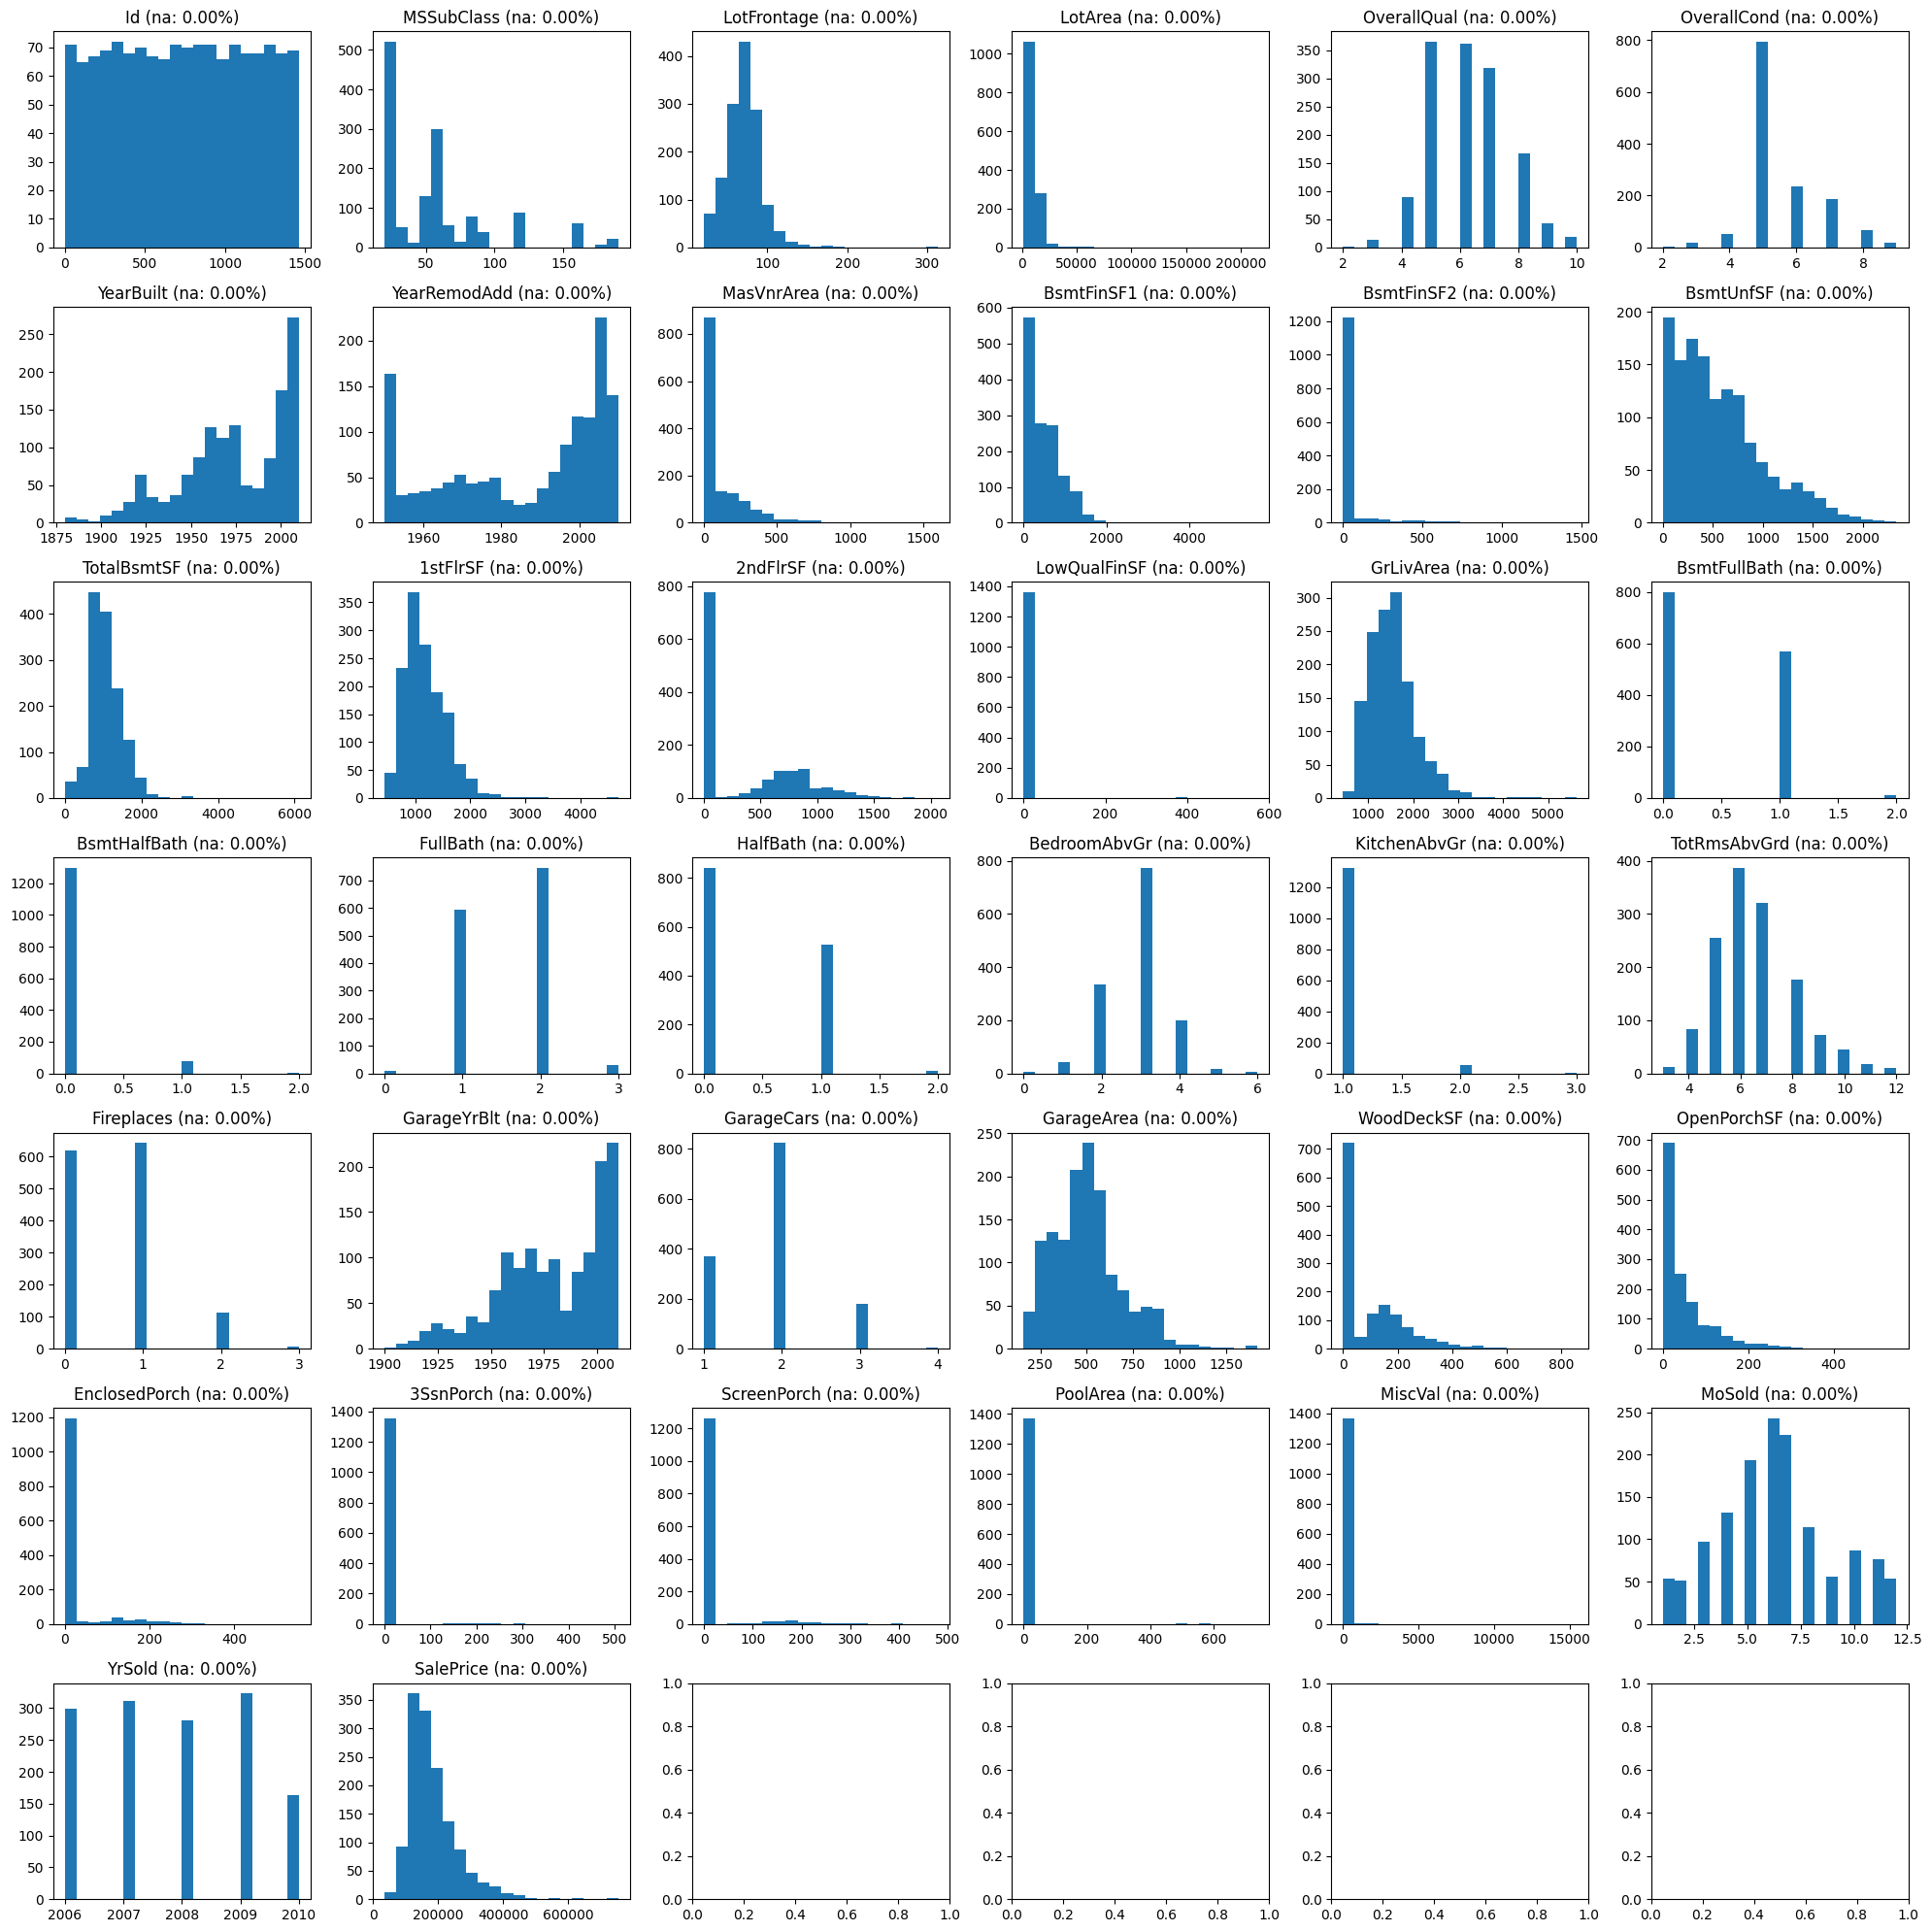

In [302]:
ajr_plot_histograms(numeric_df)

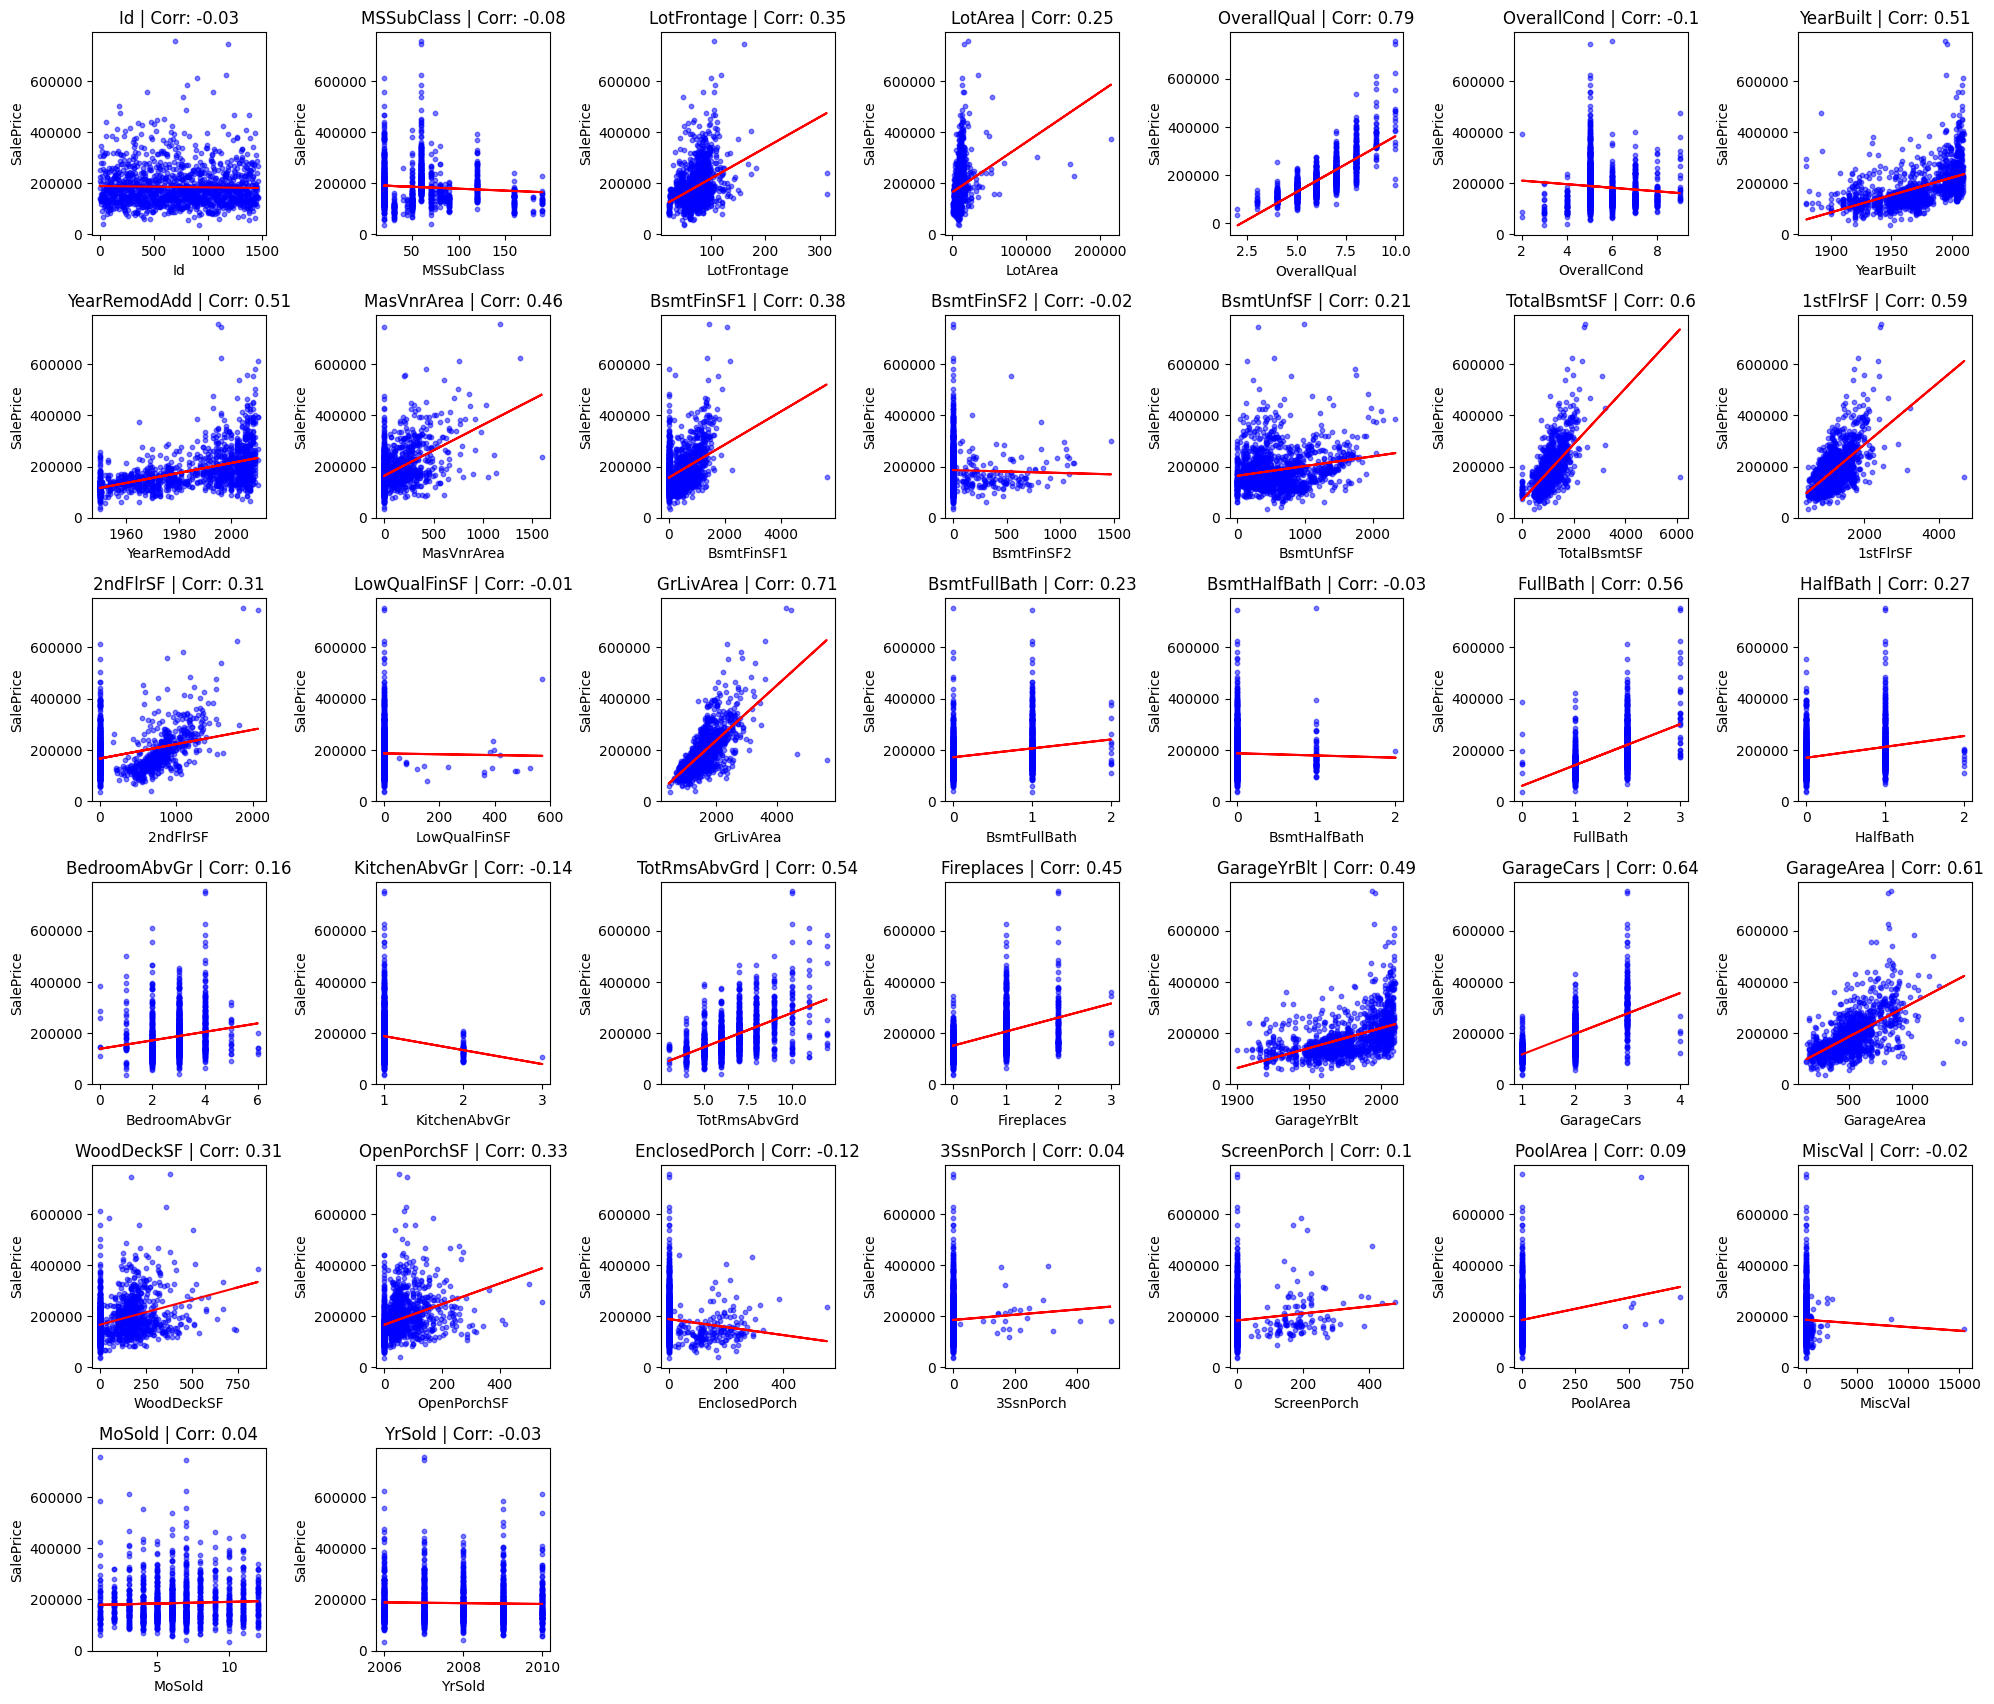

In [303]:
ajr_plot_correlations(numeric_df, 'SalePrice')

/var/folders/0f/cgwjfy6x7xl837z0mt90bnxr0000gn/T/ipykernel_57273/3908779770.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


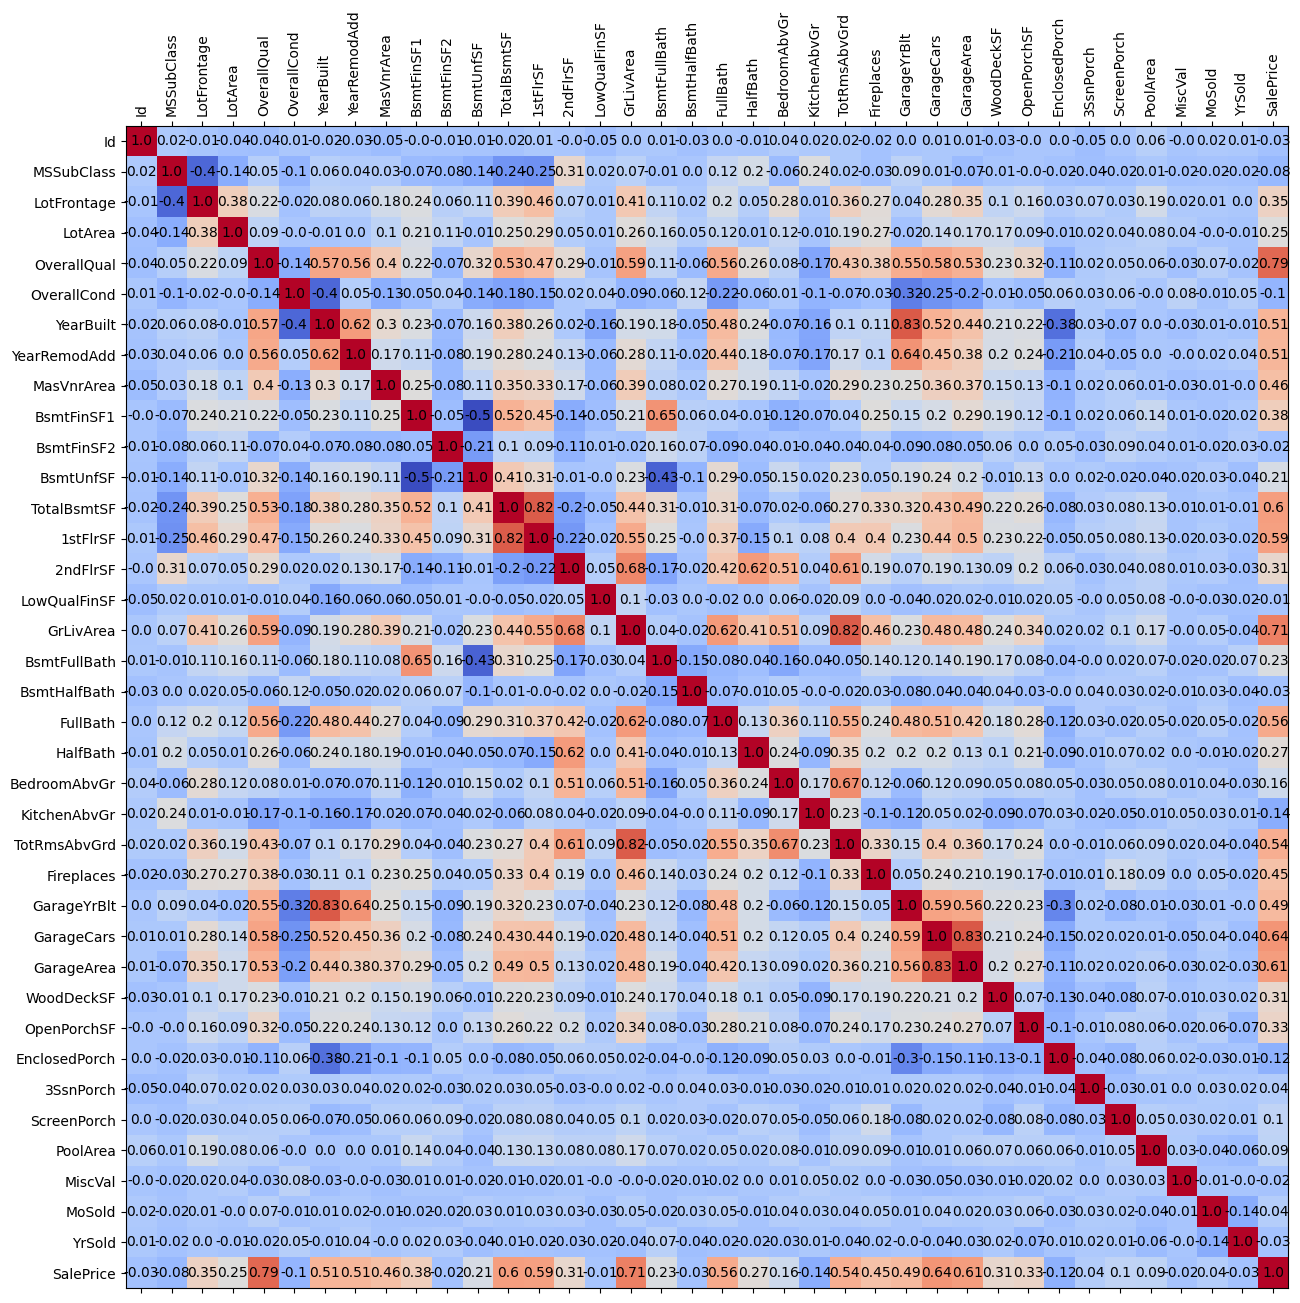

In [317]:
numeric_corr = numeric_df.corr()

def ajr_correlation_plot(corr_df: pd.DataFrame):
    column_names = list(corr_df.columns.values)
    plt.figure(figsize=(15, 15))
    plt.matshow(corr_df, cmap='coolwarm', fignum=1)
    plt.xticks(np.arange(len(column_names)), column_names, rotation=90)
    plt.yticks(np.arange(len(column_names)), column_names)
    plt.tight_layout()
    
    for i in range(len(corr_df.columns)):
        for j in range(len(corr_df.columns)):
            plt.text(j, i, f"{round(corr_df.iloc[i, j], 2)}", ha='center', va='center', color='black')

ajr_correlation_plot(numeric_corr)